### Mutual information analysis

In this notebook we use the autoregressive example model from Dhamala et. al.. The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index, such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that $X_2(t)$ influences $X_1(t)$ through the coupling constant $C$ (although the opposite does not happen). In the simulation $C(t)=0.25$ for $t=15$ s, and zero otherwise.

In [1]:
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt

from frites.estimator import GCMIEstimator, CorrEstimator, DcorrEstimator
from frites.conn      import conn_dfc, define_windows

from tqdm             import tqdm

#### Defining function to simulate de model

In [2]:
def ar_model_dhamala(N=5000, Trials = 10, Fs = 200, C=0.2, t_start=0, t_stop=None, cov = None):
    ''' 
        AR model from Dhamala et. al.
    '''
    
    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N]) 
    Y = np.random.random([Trials, N]) 

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in tqdm( range(Trials) ):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N): 
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] + E[t,1]

    Z = np.zeros([Trials,2,N]) 

    Z[:,0,:] = X 
    Z[:,1,:] = Y 

    return Z

#### Model parameters

In [3]:
N  = 5000      # Number of observations
Fs = 200       # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C  = 0.25      # Coupling parameter
Trials = 100   # Number of trials
freqs  = np.arange(1,100,1) # Frequency axis
# Covariance matrix
cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])

In [4]:
# Generating data
X = ar_model_dhamala(N=N, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=15, cov=cov)

100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


In [5]:
X = xr.DataArray(X, dims=('trials', 'roi', 'times'),
                 coords=(np.arange(Trials), ['r0', 'r1'], np.arange(N) / Fs))

#### Lagged MI

In [6]:
def delayed_mutual_information(data, win, delay=0):
    # Apply delay
    datad = data.copy()
    datad[:,0,:] = np.roll(datad[:,0,:], delay, axis=-1)

    est = GCMIEstimator('cc', copnorm=None, biascorrect=True, demeaned=False)

    # compute the dfc
    dfc = conn_dfc(datad, times='times', roi='roi', win_sample=sl_win, estimator=est)
    
    return dfc

In [7]:
slwin_len  = 1    # windows of length 50ms
slwin_step = 0.1  # 20ms step between each window (or 480ms overlap)
# define the sliding windows
sl_win, twin = define_windows(X.times.values, slwin_len=slwin_len, slwin_step=slwin_step)
# define delays
delays = np.arange(0, 10, 1, dtype=int)

Defining temporal windows
    Definition of sliding windows (len=1, start=0.0, stop=24.995, step=0.1)
    240 windows defined


In [8]:
MI = np.zeros((Trials, len(twin), len(delays)))
for i in tqdm( range( delays.shape[0] ) ):
    MI[...,i] = delayed_mutual_information(X, sl_win, delay=delays[i]).isel(roi=0)

  0%|          | 0/10 [00:00<?, ?it/s]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 10%|█         | 1/10 [00:02<00:20,  2.32s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 20%|██        | 2/10 [00:04<00:18,  2.37s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 30%|███       | 3/10 [00:07<00:17,  2.44s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 40%|████      | 4/10 [00:09<00:14,  2.49s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 50%|█████     | 5/10 [00:13<00:13,  2.66s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 60%|██████    | 6/10 [00:15<00:10,  2.61s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 70%|███████   | 7/10 [00:18<00:07,  2.64s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 80%|████████  | 8/10 [00:21<00:05,  2.74s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]

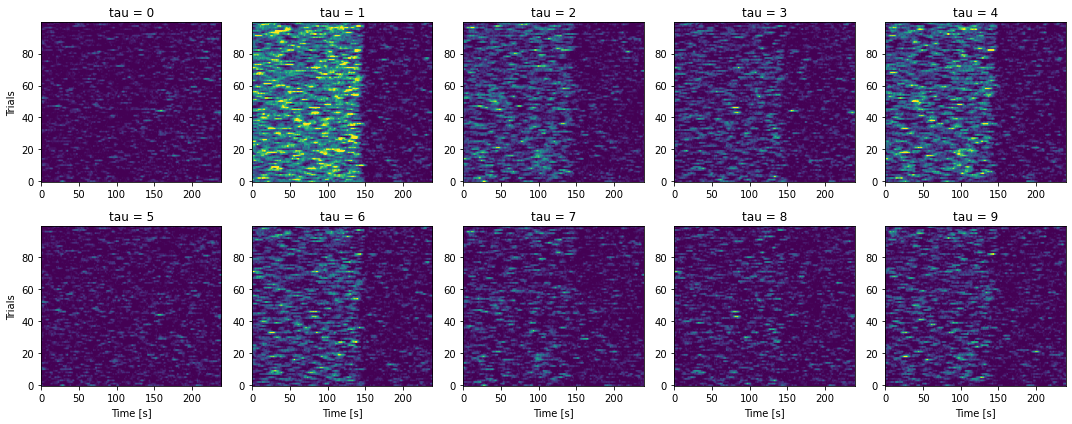

In [9]:
plt.figure(figsize=(15,6))
for i in range( delays.shape[0] ):
    plt.subplot(2,5,i+1)
    plt.imshow(MI[...,i], aspect="auto", cmap="viridis", origin="lower", vmin=0, vmax=0.3)
    if i==0 or i==5: plt.ylabel("Trials")
    if i>=5: plt.xlabel("Time [s]")
    plt.title(f"tau = {delays[i]}")
plt.tight_layout()

#### Lagged MI - frequency specificity

In [10]:
from mne.filter import filter_data

In [11]:
freqs = np.array([[0,10],
                  [10,30],
                  [30,50],
                  [50,70]])

In [12]:
Xf = []
for fb in freqs:
    Xf += [filter_data(X, Fs, fb[0], fb[1], method='iir')]
Xf = np.stack(Xf,axis=0)

Setting up low-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-pass filter from 10 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 30.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 30 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 50.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 50 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after fo

In [13]:
Xf = xr.DataArray(Xf, dims=("freqs", 'trials', 'roi', 'times'),
                 coords=(freqs.mean(axis=1), np.arange(Trials), ['r0', 'r1'], np.arange(N) / Fs))

In [14]:
fMI = np.zeros((Trials, len(twin), len(freqs)))
for i in tqdm( range( freqs.shape[0] ) ):
    fMI[...,i] = delayed_mutual_information(Xf.isel(freqs=i), sl_win, delay=1).isel(roi=0)

  0%|          | 0/4 [00:00<?, ?it/s]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 50%|█████     | 2/4 [00:04<00:04,  2.23s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


 75%|███████▌  | 3/4 [00:06<00:02,  2.22s/it]Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=None, biascorrect=True, demeaned=False)
Computing DFC between 1 pairs (gcrn=False)


100%|██████████| 4/4 [00:08<00:00,  2.24s/it]

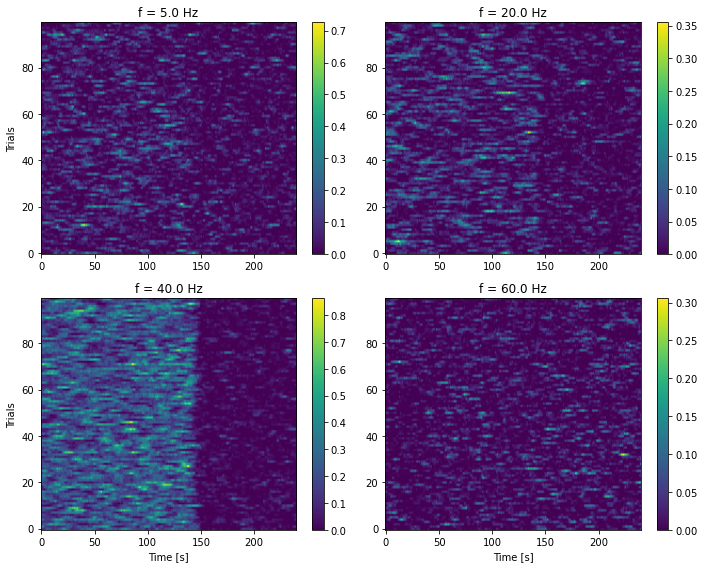

In [15]:
plt.figure(figsize=(10,8))
for i in range( freqs.shape[0] ):
    plt.subplot(2,2,i+1)
    plt.imshow(fMI[...,i], aspect="auto", cmap="viridis", origin="lower", vmin=0)
    plt.colorbar()
    if i==0 or i==2: plt.ylabel("Trials")
    if i>=2: plt.xlabel("Time [s]")
    plt.title(f"f = {Xf.freqs.values[i]} Hz")
plt.tight_layout()